#✔ Install Required Libraries

In [2]:
!pip install kaggle --quiet
!pip install tensorflow matplotlib seaborn --quiet

#✔ Upload Kaggle API Token

Go to https://www.kaggle.com/settings

Scroll down to “API” and click “Create New API Token”

Upload the kaggle.json file in Colab

# ✔ Mount your Google Drive to read the content

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
kaggle_api = '/content/drive/My\ Drive/Data Science Training/kaggle.json'

In [7]:
# Copy Kaggle API Key from Drive to .kaggle/
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/Data\ Science\ Training/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# ✔ Download FER2013 Dataset from Kaggle

In [8]:
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.17GB/s]


# ✔ Set Up Image Data Loaders

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directory
train_dir = "/content/train"
test_dir = "/content/test"

# Create ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of training data for validation
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training generator (20% of train data)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='sparse', # categorical
    subset='training',
    shuffle=True
)

# Validation generator (20% of train data)
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='sparse',
    subset='validation',
    shuffle=True
)

# Test generator (no split needed)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='sparse',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# ✔ Build the CNN Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Dropout(0.5),

    Flatten(),
    Dense(512, activation='relu',kernel_initializer='he_uniform'),
    Dense(7, activation='softmax')  # 7 classes
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 23, 23, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,935 (2.00 MB)

 Trainable params: 523,975 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

# ✔ Train the Model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint], #early_stop,
    epochs=100
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.2018 - loss: 2.2621

359/359 ━━━━━━━━━━━━━━━━━━━━ 141s 377ms/step - accuracy: 0.2018 - loss: 2.2617 - val_accuracy: 0.2520 - val_loss: 1.8178
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.2295 - loss: 1.9280

359/359 ━━━━━━━━━━━━━━━━━━━━ 134s 374ms/step - accuracy: 0.2295 - loss: 1.9280 - val_accuracy: 0.2658 - val_loss: 1.8127
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2474 - loss: 1.8411

359/359 ━━━━━━━━━━━━━━━━━━━━ 132s 366ms/step - accuracy: 0.2474 - loss: 1.8410 - val_accuracy: 0.2703 - val_loss: 1.8191
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 364ms/step - accuracy: 0.2785 - loss: 1.7795 - val_accuracy: 0.2646 - val_loss: 2.0328
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.2962 - loss: 1.7317

359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 363ms/step - accuracy: 0.2962 - loss: 1.7317 - val_accuracy: 0.3280 - val_loss: 1.6715
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 132s 368ms/step - accuracy: 0.3321 - loss: 1.6743 - val_accuracy: 0.3269 - val_loss: 1.6846
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.3525 - loss: 1.6360

359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 359ms/step - accuracy: 0.3525 - loss: 1.6360 - val_accuracy: 0.3531 - val_loss: 1.6496
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.3681 - loss: 1.5998

359/359 ━━━━━━━━━━━━━━━━━━━━ 136s 380ms/step - accuracy: 0.3681 - loss: 1.5998 - val_accuracy: 0.3616 - val_loss: 1.6450
Epoch 9/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.3876 - loss: 1.5585

359/359 ━━━━━━━━━━━━━━━━━━━━ 137s 381ms/step - accuracy: 0.3876 - loss: 1.5586 - val_accuracy: 0.4001 - val_loss: 1.5586
Epoch 10/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 133s 370ms/step - accuracy: 0.4007 - loss: 1.5418 - val_accuracy: 0.3905 - val_loss: 1.5609
Epoch 11/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.4136 - loss: 1.5180

359/359 ━━━━━━━━━━━━━━━━━━━━ 145s 378ms/step - accuracy: 0.4136 - loss: 1.5180 - val_accuracy: 0.4377 - val_loss: 1.4692
Epoch 12/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 359ms/step - accuracy: 0.4164 - loss: 1.4970 - val_accuracy: 0.4003 - val_loss: 1.5460
Epoch 13/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4294 - loss: 1.4733

359/359 ━━━━━━━━━━━━━━━━━━━━ 147s 372ms/step - accuracy: 0.4294 - loss: 1.4733 - val_accuracy: 0.4457 - val_loss: 1.4333
Epoch 14/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 361ms/step - accuracy: 0.4400 - loss: 1.4494 - val_accuracy: 0.4093 - val_loss: 1.5148
Epoch 15/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.4381 - loss: 1.4422

359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 364ms/step - accuracy: 0.4381 - loss: 1.4423 - val_accuracy: 0.4701 - val_loss: 1.3894
Epoch 16/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 364ms/step - accuracy: 0.4535 - loss: 1.4283 - val_accuracy: 0.3691 - val_loss: 1.5942
Epoch 17/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 128s 356ms/step - accuracy: 0.4547 - loss: 1.4142 - val_accuracy: 0.4189 - val_loss: 1.5090
Epoch 18/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 133s 369ms/step - accuracy: 0.4542 - loss: 1.4136 - val_accuracy: 0.4456 - val_loss: 1.4220
Epoch 19/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 364ms/step - accuracy: 0.4619 - loss: 1.3983 - val_accuracy: 0.4605 - val_loss: 1.4175
Epoch 20/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 359ms/step - accuracy: 0.4704 - loss: 1.3808 - val_accuracy: 0.4583 - val_loss: 1.4070
Epoch 21/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 363ms/step - accuracy: 0.4682 - loss: 1.3920 - val_accuracy: 0.4457 - val_loss: 1.4486
Epoch 22/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.4786 

359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 366ms/step - accuracy: 0.4786 - loss: 1.3642 - val_accuracy: 0.4774 - val_loss: 1.3536
Epoch 23/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.4783 - loss: 1.3615

359/359 ━━━━━━━━━━━━━━━━━━━━ 139s 358ms/step - accuracy: 0.4783 - loss: 1.3616 - val_accuracy: 0.4963 - val_loss: 1.3232
Epoch 24/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 133s 372ms/step - accuracy: 0.4820 - loss: 1.3677 - val_accuracy: 0.4907 - val_loss: 1.3239
Epoch 25/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 363ms/step - accuracy: 0.4798 - loss: 1.3603 - val_accuracy: 0.4816 - val_loss: 1.3583
Epoch 26/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 132s 367ms/step - accuracy: 0.4866 - loss: 1.3499 - val_accuracy: 0.4551 - val_loss: 1.4333
Epoch 27/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 132s 367ms/step - accuracy: 0.4772 - loss: 1.3668 - val_accuracy: 0.4508 - val_loss: 1.4110
Epoch 28/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.4822 - loss: 1.3449

359/359 ━━━━━━━━━━━━━━━━━━━━ 138s 383ms/step - accuracy: 0.4822 - loss: 1.3449 - val_accuracy: 0.5015 - val_loss: 1.2923
Epoch 29/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 136s 367ms/step - accuracy: 0.4937 - loss: 1.3278 - val_accuracy: 0.3740 - val_loss: 1.5772
Epoch 30/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 359ms/step - accuracy: 0.4889 - loss: 1.3403 - val_accuracy: 0.4886 - val_loss: 1.3159
Epoch 31/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.4892 - loss: 1.3353

359/359 ━━━━━━━━━━━━━━━━━━━━ 134s 372ms/step - accuracy: 0.4892 - loss: 1.3353 - val_accuracy: 0.5102 - val_loss: 1.2838
Epoch 32/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 141s 370ms/step - accuracy: 0.4825 - loss: 1.3336 - val_accuracy: 0.4971 - val_loss: 1.3180
Epoch 33/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 132s 367ms/step - accuracy: 0.4938 - loss: 1.3224 - val_accuracy: 0.4959 - val_loss: 1.3173
Epoch 34/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 360ms/step - accuracy: 0.5019 - loss: 1.3124 - val_accuracy: 0.5100 - val_loss: 1.2886
Epoch 35/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 144s 364ms/step - accuracy: 0.5016 - loss: 1.3026 - val_accuracy: 0.5030 - val_loss: 1.2886
Epoch 36/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 128s 356ms/step - accuracy: 0.5048 - loss: 1.2942 - val_accuracy: 0.5001 - val_loss: 1.3169
Epoch 37/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.4948 - loss: 1.3094

359/359 ━━━━━━━━━━━━━━━━━━━━ 134s 371ms/step - accuracy: 0.4948 - loss: 1.3094 - val_accuracy: 0.5255 - val_loss: 1.2497
Epoch 38/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 360ms/step - accuracy: 0.5006 - loss: 1.3090 - val_accuracy: 0.5184 - val_loss: 1.2530
Epoch 39/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5091 - loss: 1.2921

359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 360ms/step - accuracy: 0.5091 - loss: 1.2921 - val_accuracy: 0.5267 - val_loss: 1.2406
Epoch 40/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 362ms/step - accuracy: 0.5051 - loss: 1.2971 - val_accuracy: 0.5133 - val_loss: 1.2624
Epoch 41/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 365ms/step - accuracy: 0.5041 - loss: 1.2942 - val_accuracy: 0.5245 - val_loss: 1.2588
Epoch 42/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5108 - loss: 1.2920

359/359 ━━━━━━━━━━━━━━━━━━━━ 127s 355ms/step - accuracy: 0.5108 - loss: 1.2920 - val_accuracy: 0.5424 - val_loss: 1.2043
Epoch 43/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 132s 368ms/step - accuracy: 0.5070 - loss: 1.2995 - val_accuracy: 0.5149 - val_loss: 1.2818
Epoch 44/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 362ms/step - accuracy: 0.5073 - loss: 1.2847 - val_accuracy: 0.4820 - val_loss: 1.3253
Epoch 45/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 365ms/step - accuracy: 0.5098 - loss: 1.2794 - val_accuracy: 0.5233 - val_loss: 1.2500
Epoch 46/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 362ms/step - accuracy: 0.5072 - loss: 1.2895 - val_accuracy: 0.5379 - val_loss: 1.2014
Epoch 47/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 144s 369ms/step - accuracy: 0.5140 - loss: 1.2850 - val_accuracy: 0.5118 - val_loss: 1.2684
Epoch 48/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 126s 352ms/step - accuracy: 0.5217 - loss: 1.2660 - val_accuracy: 0.4957 - val_loss: 1.2980
Epoch 49/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 133s 370ms/step - accuracy: 0.525

359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 358ms/step - accuracy: 0.5181 - loss: 1.2628 - val_accuracy: 0.5450 - val_loss: 1.2074
Epoch 55/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 363ms/step - accuracy: 0.5181 - loss: 1.2591 - val_accuracy: 0.5337 - val_loss: 1.2331
Epoch 56/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 366ms/step - accuracy: 0.5156 - loss: 1.2625 - val_accuracy: 0.4963 - val_loss: 1.3366
Epoch 57/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 134s 373ms/step - accuracy: 0.5183 - loss: 1.2594 - val_accuracy: 0.5097 - val_loss: 1.2971
Epoch 58/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 362ms/step - accuracy: 0.5127 - loss: 1.2704 - val_accuracy: 0.5356 - val_loss: 1.2218
Epoch 59/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 359ms/step - accuracy: 0.5207 - loss: 1.2527 - val_accuracy: 0.5112 - val_loss: 1.2826
Epoch 60/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5161 - loss: 1.2614

359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 361ms/step - accuracy: 0.5161 - loss: 1.2614 - val_accuracy: 0.5476 - val_loss: 1.1916
Epoch 61/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 133s 371ms/step - accuracy: 0.5273 - loss: 1.2437 - val_accuracy: 0.5029 - val_loss: 1.2994
Epoch 62/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 363ms/step - accuracy: 0.5296 - loss: 1.2449 - val_accuracy: 0.5071 - val_loss: 1.2649
Epoch 63/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 363ms/step - accuracy: 0.5321 - loss: 1.2435 - val_accuracy: 0.4123 - val_loss: 1.4730
Epoch 64/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 143s 367ms/step - accuracy: 0.5199 - loss: 1.2620 - val_accuracy: 0.5426 - val_loss: 1.2133
Epoch 65/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 134s 373ms/step - accuracy: 0.5240 - loss: 1.2435 - val_accuracy: 0.5253 - val_loss: 1.2121
Epoch 66/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 360ms/step - accuracy: 0.5259 - loss: 1.2439 - val_accuracy: 0.5361 - val_loss: 1.2028
Epoch 67/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 146s 371ms/step - accuracy: 0.519

359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 360ms/step - accuracy: 0.5254 - loss: 1.2467 - val_accuracy: 0.5520 - val_loss: 1.1829
Epoch 75/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 366ms/step - accuracy: 0.5273 - loss: 1.2355 - val_accuracy: 0.5260 - val_loss: 1.2497
Epoch 76/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 127s 354ms/step - accuracy: 0.5364 - loss: 1.2267 - val_accuracy: 0.5476 - val_loss: 1.1839
Epoch 77/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 148s 369ms/step - accuracy: 0.5395 - loss: 1.2213 - val_accuracy: 0.5508 - val_loss: 1.1841
Epoch 78/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.5321 - loss: 1.2330

359/359 ━━━━━━━━━━━━━━━━━━━━ 136s 380ms/step - accuracy: 0.5321 - loss: 1.2330 - val_accuracy: 0.5576 - val_loss: 1.1733
Epoch 79/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 136s 379ms/step - accuracy: 0.5308 - loss: 1.2299 - val_accuracy: 0.5032 - val_loss: 1.2925
Epoch 80/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 133s 369ms/step - accuracy: 0.5386 - loss: 1.2237 - val_accuracy: 0.5563 - val_loss: 1.1683
Epoch 81/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 145s 404ms/step - accuracy: 0.5385 - loss: 1.2151 - val_accuracy: 0.5407 - val_loss: 1.2051
Epoch 82/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5398 - loss: 1.2154

359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 363ms/step - accuracy: 0.5398 - loss: 1.2154 - val_accuracy: 0.5605 - val_loss: 1.1672
Epoch 83/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 361ms/step - accuracy: 0.5344 - loss: 1.2300 - val_accuracy: 0.5339 - val_loss: 1.2209
Epoch 84/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 358ms/step - accuracy: 0.5353 - loss: 1.2185 - val_accuracy: 0.5593 - val_loss: 1.1812
Epoch 85/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 364ms/step - accuracy: 0.5440 - loss: 1.2150 - val_accuracy: 0.5471 - val_loss: 1.1976
Epoch 86/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 140s 357ms/step - accuracy: 0.5339 - loss: 1.2211 - val_accuracy: 0.5483 - val_loss: 1.1843
Epoch 87/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 133s 370ms/step - accuracy: 0.5386 - loss: 1.2173 - val_accuracy: 0.5220 - val_loss: 1.2441
Epoch 88/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5397 - loss: 1.2127

359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 365ms/step - accuracy: 0.5397 - loss: 1.2127 - val_accuracy: 0.5663 - val_loss: 1.1581
Epoch 89/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 362ms/step - accuracy: 0.5338 - loss: 1.2226 - val_accuracy: 0.5116 - val_loss: 1.2935
Epoch 90/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 363ms/step - accuracy: 0.5402 - loss: 1.2128 - val_accuracy: 0.5363 - val_loss: 1.2236
Epoch 91/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 132s 369ms/step - accuracy: 0.5370 - loss: 1.2242 - val_accuracy: 0.5581 - val_loss: 1.1652
Epoch 92/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 128s 358ms/step - accuracy: 0.5375 - loss: 1.2267 - val_accuracy: 0.5412 - val_loss: 1.2119
Epoch 93/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 136s 377ms/step - accuracy: 0.5411 - loss: 1.2092 - val_accuracy: 0.5494 - val_loss: 1.1781
Epoch 94/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 362ms/step - accuracy: 0.5393 - loss: 1.2076 - val_accuracy: 0.5509 - val_loss: 1.1744
Epoch 95/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 365ms/step - accuracy: 0.541

# ✔ Evaluate the Test Data


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.4909 - loss: 1.2562
Test Accuracy: 0.6027


# ✔ Plot Training and Validation Metrics

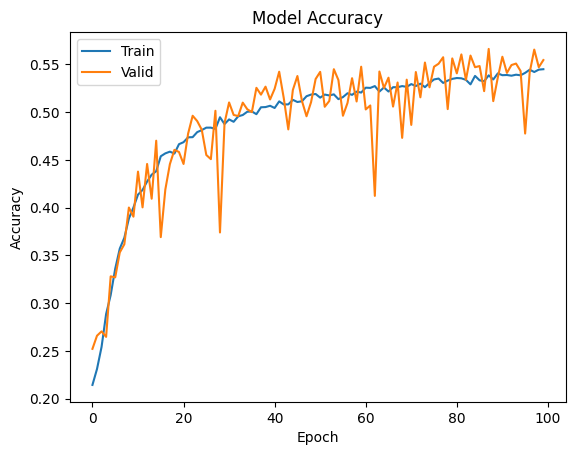

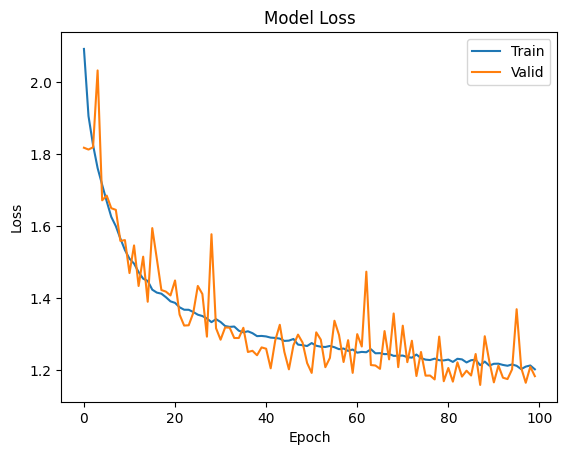

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ✔ Inference on a single image

In [ ]:
class_labels = list(train_generator.class_indices.keys())

In [ ]:
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
import os

def predict_emotion(img_path):
    # Get actual class name from file path
    actual_label = os.path.basename(os.path.dirname(img_path))

    # Load and preprocess image
    img = image.load_img(img_path, color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]

    # Display image with actual & predicted label
    plt.imshow(img_array[0].squeeze(), cmap='gray')
    plt.title(f"Actual: {actual_label.capitalize()} | Predicted: {predicted_label.capitalize()}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


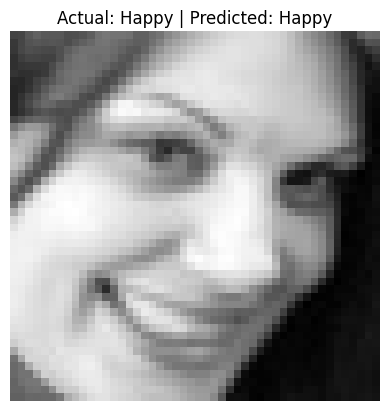

In [ ]:
predict_emotion("/content/test/happy/PrivateTest_13103594.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


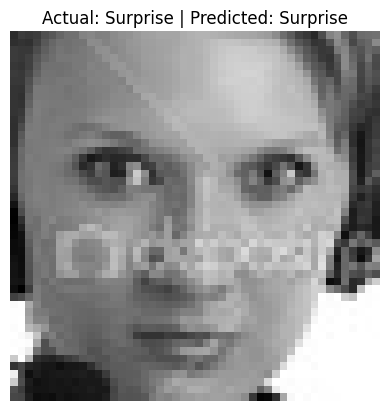

In [ ]:
predict_emotion("/content/test/surprise/PrivateTest_13683211.jpg")

In [ ]:
model=model.save('emotion_model.h5')